# 10 RNN을 이용한 텍스트 분류

### 1) 케라스를 이용한 텍스트 분류

1. 훈련 데이터 이해

2. 훈련 데이터와 테스트 데이터

3. 단어에 대한 정수 부여

4. RNN으로 분류

5. RNN의 다-대-일 문제

  텍스트 분류는 모든 시점에 대해서 입력을 받지만, 최종 시점의 RNN 셀만이 은닉 상태를 출력하고, 이것이 출력층으로 가서 활성화 함수를 통해 정답을 고르는 문제가 된다. 

### 2) 스팸 메일 분류



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')

data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [2]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])

In [3]:
# v2 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['v2'], inplace=True)

In [4]:
X_data = data['v2']
y_data = data['v1']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
word_to_index = tokenizer.word_index

vocab_size = len(word_to_index) + 1
print('메일의 최대 길이 : %d' % max(len(sample) for sample in X_train_encoded))

메일의 최대 길이 : 189


In [6]:
max_len = 189
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)

In [7]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_padded, y_train, epochs=4, batch_size=64, validation_split=0.2)

X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

Epoch 1/4
52/52 [==============================] - 5s 54ms/step - loss: 0.3826 - acc: 0.8839 - val_loss: 0.2136 - val_acc: 0.9238
Epoch 2/4
52/52 [==============================] - 2s 47ms/step - loss: 0.1645 - acc: 0.9513 - val_loss: 0.1073 - val_acc: 0.9710
Epoch 3/4
52/52 [==============================] - 3s 56ms/step - loss: 0.0698 - acc: 0.9822 - val_loss: 0.0792 - val_acc: 0.9758
Epoch 4/4
33/33 [==============================] - 0s 12ms/step - loss: 0.0681 - acc: 0.9797

 테스트 정확도: 0.9797


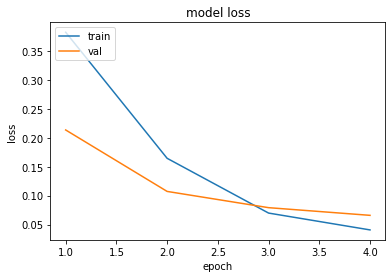

In [8]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 3) 로이터 뉴스 분류



In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

print('뉴스 기사의 최대 길이 :{}'.format(max(len(sample) for sample in X_train)))

index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

2121728/2110848 [==============================] - 0s 0us/step
뉴스 기사의 최대 길이 :2376


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

vocab_size = 1000
max_len = 100

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
embedding_dim = 128
hidden_units = 128
num_classes = 46

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=10, callbacks=[es, mc], validation_data=(X_test, y_test))

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 2.6251 - acc: 0.3358
Epoch 1: val_acc improved from -inf to 0.36198, saving model to best_model.h5
71/71 [==============================] - 33s 419ms/step - loss: 2.6251 - acc: 0.3358 - val_loss: 2.4043 - val_acc: 0.3620
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 2.1250 - acc: 0.4427
Epoch 2: val_acc improved from 0.36198 to 0.49644, saving model to best_model.h5
71/71 [==============================] - 28s 399ms/step - loss: 2.1250 - acc: 0.4427 - val_loss: 1.9198 - val_acc: 0.4964
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 1.8756 - acc: 0.5139
Epoch 3: val_acc improved from 0.49644 to 0.54497, saving model to best_model.h5
71/71 [==============================] - 29s 403ms/step - loss: 1.8756 - acc: 0.5139 - val_loss: 1.8301 - val_acc: 0.5450
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 1.7608 - acc: 0.5455
Epoch 4: val_acc improved from 0.54497

### 4) IMDB 리뷰 감성 분류하기

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data()

print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

17473536/17464789 [==============================] - 0s 0us/step
훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [16]:
reviews_length = [len(review) for review in X_train]

word_to_index = imdb.get_word_index()
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

In [17]:
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

vocab_size = 10000
max_len = 500

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [18]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=5, callbacks=[es, mc], batch_size=64, validation_split=0.2)

loaded_model = load_model('GRU_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.5185 - acc: 0.7577
Epoch 1: val_acc improved from -inf to 0.85460, saving model to GRU_model.h5
313/313 [==============================] - 275s 870ms/step - loss: 0.5185 - acc: 0.7577 - val_loss: 0.3523 - val_acc: 0.8546
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.3237 - acc: 0.8692
Epoch 2: val_acc improved from 0.85460 to 0.87000, saving model to GRU_model.h5
313/313 [==============================] - 266s 849ms/step - loss: 0.3237 - acc: 0.8692 - val_loss: 0.3507 - val_acc: 0.8700
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.2540 - acc: 0.9026
Epoch 3: val_acc did not improve from 0.87000
313/313 [==============================] - 266s 849ms/step - loss: 0.2540 - acc: 0.9026 - val_loss: 0.3632 - val_acc: 0.8464
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.2024 - acc: 0.9247
Epoch 4: val_acc improved from 0.87000 to 0.87780, saving mode

### 5) 나이브 베이즈 분류기

1. 베이즈의 정리를 이용한 분류 메커니즘

  베이즈 정리 : P(A|B) = P(B|A)P(A) / P(B)

2. 스팸 메일 분류기

  P(정상 메일 | 입력 텍스트) = (P(입력 텍스트 | 정상 메일) × P(정상 메일)) / P(입력 텍스트) = P(입력 텍스트 | 정상 메일) × P(정상 메일)
  
  P(스팸 메일 | 입력 텍스트) = (P(입력 텍스트 | 스팸 메일) × P(스팸 메일)) / P(입력 텍스트) = P(입력 텍스트 | 스팸 메일) × P(스팸 메일)

 -> 

 P(정상 메일 | 입력 텍스트) = P(w1 | 정상 메일) × P(w2 | 정상 메일) × P(w3 | 정상 메일) × P(정상 메일)

  P(스팸 메일 | 입력 텍스트) = P(w1 | 스팸 메일) × P(w2 | 스팸 메일) × P(w3 | 스팸 메일) × P(스팸 메일)

  (단어 순서 무시, 빈도수만 고려)

### 6) 네이버 영화 리뷰 감성 분류

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

print(len(train_data))
train_data.head()

150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [22]:
train_data['document'].nunique()

146182

In [23]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [24]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [25]:
train_data = train_data.dropna(how = 'any')

In [26]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [27]:
train_data = train_data.dropna(how = 'any')

In [28]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 146182/146182 [13:20<00:00, 182.54it/s]


In [30]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [04:47<00:00, 169.88it/s]


In [31]:
vocab_size = len(tokenizer.word_index) + 1

tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.289550012997497


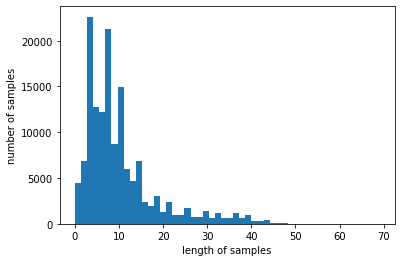

In [32]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
max_len = 30
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [34]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

Epoch 1/15
1827/1828 [============================>.] - ETA: 0s - loss: 0.3927 - acc: 0.8199
Epoch 1: val_acc improved from -inf to 0.84174, saving model to best_model.h5
1828/1828 [==============================] - 166s 89ms/step - loss: 0.3927 - acc: 0.8199 - val_loss: 0.3597 - val_acc: 0.8417
Epoch 2/15
1827/1828 [============================>.] - ETA: 0s - loss: 0.3344 - acc: 0.8530
Epoch 2: val_acc improved from 0.84174 to 0.85347, saving model to best_model.h5
1828/1828 [==============================] - 152s 83ms/step - loss: 0.3344 - acc: 0.8530 - val_loss: 0.3380 - val_acc: 0.8535
Epoch 3/15
1827/1828 [============================>.] - ETA: 0s - loss: 0.3138 - acc: 0.8643
Epoch 3: val_acc improved from 0.85347 to 0.85724, saving model to best_model.h5
1828/1828 [==============================] - 156s 85ms/step - loss: 0.3138 - acc: 0.8643 - val_loss: 0.3326 - val_acc: 0.8572
Epoch 4/15
1827/1828 [============================>.] - ETA: 0s - loss: 0.2991 - acc: 0.8719
Epoch 4: v

In [35]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [36]:
sentiment_predict('내가 뭘본지 모르겠음 ㅋㅋ')

85.84% 확률로 부정 리뷰입니다.



### 7) BiLSTM을 텍스트 분류에 사용

순방향 LSTM의 경우에는 마지막 시점의 은닉 상태를 반환

역방향 LSTM의 경우에는 첫번째 시점의 은닉 상태를 반환

model.add(Bidirectional(LSTM(hidden_units)))